# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [1]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read the *original* dataset...

In [2]:
original_df = pd.read_csv('../data/train.csv')

In [3]:
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

**TripType** is the column that we should predict. That column is not present in the test set

In [6]:
original_df.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.000000,453411.000000,4.505590e+05,453411.000000,450559.000000
mean,58.027039,95909.846115,3.075243e+10,1.108584,3727.366554
std,155.973370,55399.801147,9.163940e+10,0.707029,2779.958546
min,3.000000,5.000000,8.340000e+02,-10.000000,0.000000
25%,27.000000,49390.000000,3.400004e+09,1.000000,1404.000000
50%,39.000000,96781.000000,7.056082e+09,1.000000,3352.000000
75%,40.000000,143930.000000,3.013201e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [39]:
original_df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


Looking into the columns values...

In [40]:
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [9]:
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

There are `nan`s in the column, let us find them...

In [70]:
# Elimino los datos que tienen Nan en el Department Description
clean_df = original_df.dropna(subset=['DepartmentDescription'])

# Los datos que tienen Nan en Upc son todos de Pharmacy RX
# Luego los completo con esos valores, obtenidos por inspección
clean_df.loc[clean_df.Upc.isna(), "FinelineNumber"] = 4822
clean_df.loc[clean_df.Upc.isna(), "Upc"] = 30169183702

# Luego vemos que no tengo ningun valor Nan
clean_df[clean_df.Upc.isna()]

C:\Users\503161912\Miniconda3\envs\mentoria\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber


When the description is NaN, then the Upc and FinelineNumber are both NaN?

In [71]:
clean_df[clean_df.DepartmentDescription.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber


But it may be the case that Upc is NaN but not the description...

In [68]:
(clean_df.Upc.isna().sum(),
 clean_df.FinelineNumber.isna().sum(),
 (clean_df.FinelineNumber.isna() & clean_df.Upc.isna()).sum(), clean_df.DepartmentDescription.isna().sum())

# No tengo ningun Nan

(0, 0, 0, 0)

Upc and FinelineNumber are both NaN at the same time

Our last step in this analysis is to see how balanced is the data...

In [41]:
bins = set(clean_df.TripType)

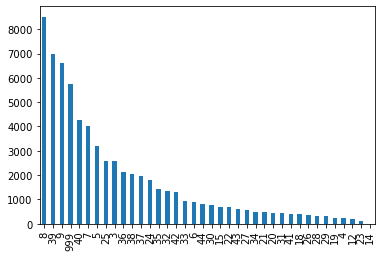

In [69]:
# to count the TripType values, we have to group the visits by VisitNumber
clean_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

**Unbalanced!!!**

Create a function to load the datasets.

**Some important decisions made here**:
1. We will use one hot encoding for Weekday and DepartmentDescription. All transformations are applied to the training and testing datasets...
1. We are handling NaN's as another category. This may not be the best approach.
1. We may have multiple records for one single visit and the goal is to classify all those records the exact same way. Therefore, we will prepare the data in a way that all the information for a visit is in the same record.
1. Based on the last bullet, we will count the DepartmentDescription for all items acquired in the same visit.
1. We drop the Upc and FinelineNumber to simplify the process. You may use it as they have a lot of information (may be using one-hot encoding for them as well)

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [43]:
df = original_df.drop(["Upc", "FinelineNumber", "TripType"], axis=1)

In [44]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription
0,5,Friday,-1,FINANCIAL SERVICES
1,9,Friday,1,IMPULSE MERCHANDISE
2,9,Friday,1,PRODUCE
3,9,Friday,1,PRODUCE
4,10,Friday,1,DSD GROCERY
...,...,...,...,...
453406,191344,Sunday,1,BEAUTY
453407,191344,Sunday,1,WIRELESS
453408,191344,Sunday,1,BEAUTY
453409,191347,Sunday,1,DAIRY


Now, we create the dummy columns

In [45]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

In [46]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,...,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,Friday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,Friday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,Friday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453406,191344,Sunday,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
453407,191344,Sunday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
453408,191344,Sunday,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
453409,191347,Sunday,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we group by the VisitNumber and Weekday (they should be the same), and add all values for ScanCount, and the one-hot encoding of DepartmentDescriptioin

In [47]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()

In [48]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,...,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,Friday,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,Friday,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,Friday,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,Friday,7,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67024,191329,Sunday,20,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
67025,191337,Sunday,27,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67026,191343,Sunday,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67027,191344,Sunday,5,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,1,0


In [76]:
def transform_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

Load the data...

In [77]:
X, y, XX, yy = transform_data("../data/train.csv", "../data/test.csv")

Create the model and evaluate it

In [51]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))

In [53]:
# we will use a DesicionTree to classify and GridSearch to determine the parameters
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100)}
tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')
tree_clf.fit(X_train, y_train)
best_tree_clf = tree_clf.best_estimator_

In [54]:
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

Best Decision Tree accuracy:  0.6304134697357204
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


**And finally**, we predict the unknown label for the testing set

In [55]:
X.shape, XX.shape

((67029, 79), (28645, 79))

In [56]:
yy = results.clf.iloc[0].predict(XX)

The last thing we do is generating a file that should be *submitted* on kaggle

In [57]:
submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])

In [58]:
submission.to_csv("../data/submission.csv", header=True, index=False)

### Cosas para hacer:
##### Eliminar los Nan
##### Corroborar que los triptype para los registros de la misma compra dan igual
##### Relación entre finenumber y upc